# Assignment 2:  Implicit Neural Representation

Name: **Omkar Chittar**
----------------------------

 Hands-on experience with implicit neural representation (INR). With INR, we parameterize some signal (in our case images) with a neural network (in this assignment, we will use a basic feed-forward network). While in practice this might be useful for outpainting, super-resolution, and compression, in this assignment we will mainly focus on the basics, with some proof-of-concept outpainting at the end. Your outputs might not look great, this is okay as long as they are at least as good as the examples.

## Dataset

As always, we start with the data. In this section, you will need to complete the following steps:

1. Choose an image. If you're working in colab, you will need to either mount your Google Drive, or else upload the file directly.
2. Write SingleImageDataset. This is how you'll convert your image into model inputs and targets. You will instantiate the dataset and a dataloader to check and make sure you did this part correctly.

Mounting my drive

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


### Question 1: Selecting an image (5 points)

Free points! Just show your image here. One catch- make sure the image is less than 62500 pixels, total. We do not want you to waste time waiting for your model to train.

torch.Size([3, 250, 250])


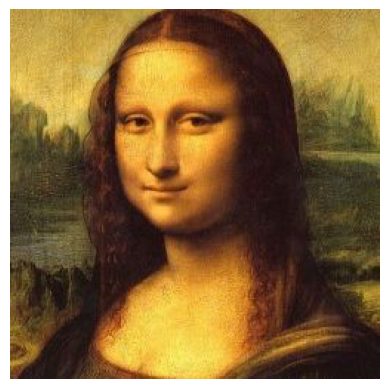

In [1]:
from torchvision.io import read_image  ## Note: feel free to use another loader
import matplotlib.pyplot as plt

image = read_image("data/mona.jpeg")
print(image.shape)
# because the image is loaded as a tensor, the shape of the image is (3, 255, 255)
plt.imshow(image.permute(1, 2, 0).cpu().numpy())
plt.axis('off')
plt.show()
plt.close()

### Question 2: Writing the dataset (20 points)

For this part, you need to fill in the blanks for the dataset provided below. Alternatively, feel free to write it from scratch, the scaffolding was provided to help you, not to trap you in a box.

You will also need to write a loop to construct the image, using a dataloader for your SingleImageDataset. We provide more details in comments below.

We will be grading your code and your image outputs. In Gradescope, make sure both are fully visible.

In [4]:
from torchvision.io import read_image
from torch.utils.data import Dataset

class SingleImageDataset(Dataset):
    def __init__(self, img_path):
        self.image = read_image(img_path)
        self.num_channels, self.h, self.w = self.image.shape

    def __len__(self):
        ### TODO: 1 line of code for returning the number of pixels
        self.num_pixels = self.h * self.w
        return self.h * self.w

    def __getitem__(self, idx):
        ### TODO: 2-3 lines of code for x, y, and pixel values
        # given an index in a flatenned array i need to find the x, y and intensity value
        y, x = divmod(idx, self.w)  # Calculate the (y, x) coordinates from the 1D index
        intensity = self.image[:, y, x].float()  # Extract pixel intensity values
        return {"x": x, "y": y, "intensity": intensity}  # returning as a dictionary

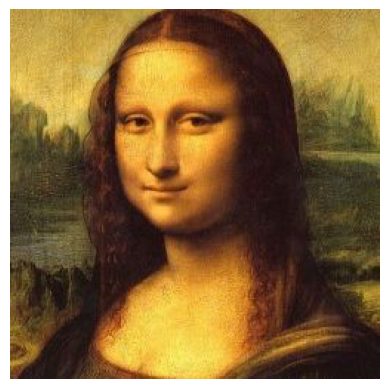

In [5]:
from pickle import TRUE
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

dataset = SingleImageDataset("data/mona.jpeg")

### TODO: 1 line of code for initializing a DataLoader
dataloader = DataLoader(dataset, shuffle=False, batch_size=1)

### TODO: 6-10 lines of code for using your dataloader to retrieve, reassemble,
###       and display your image
some_image = torch.zeros(image.shape)

for batch in dataloader:
    x, y, intensity = batch["x"], batch["y"], batch["intensity"]
    some_image[:, y, x] = intensity[0, :].unsqueeze(1)

plt.imshow((some_image).permute(1, 2, 0).numpy().astype(np.uint8))
plt.axis('off')
plt.show()

## Network


### Question 3: Defining the Network (15 points)

Define a feedforward neural network.
Remember that the last layer output dimension should be equal to the number of color channels.

A very basic network might have a linear layer, followed by a ReLU, followed by another linear layer.

In [6]:
from torch.nn import Sigmoid
class FFN(torch.nn.Module):
    def __init__(self):
        super(FFN, self).__init__()
        ### TODO: define and initialize some layers with weights
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(2, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 3),
        )

    def forward(self, coord):
        out = self.layers(coord)
        return out


## Training

Now that you have a dataset and model, time to put it together!

Instantiate an optimizer and a criterion.
Loop over your dataset until the network converges.
Track your loss. We will be asking you to plot it later.

In [7]:
from tqdm import tqdm

dataloader = DataLoader(dataset, shuffle=True, batch_size=64)

net = FFN()  # Initialize your neural network

# Since we are training the network for pixels, we will do a pixelwise MSE loss
criterion = torch.nn.MSELoss()

# TODO: Choose the optimizer (e.g., Adam) and set the learning rate and other parameters.
optimizer = torch.optim.Adam(net.parameters(), lr=0.0008)  # Adjust the learning rate as needed.
NUM_EPOCHS = 25  # Choose the number of epochs as needed.

# Set up mechanism for storing loss values
loss_values = []

for epoch in tqdm(range(NUM_EPOCHS)):
    results = []
    for batch in dataloader:
        x, y, actual = batch["x"], batch["y"], batch["intensity"]
        x = x / dataset.w  # Normalizing x between 0 and 1
        y = y / dataset.h  # Normalizing y between 0 and 1

        # Assemble the coordinates from x and y
        coord = torch.stack((x, y), dim=-1)

        # Forward pass to get predictions
        pred = net.forward(coord)

        # Calculate the loss
        loss = criterion(pred, actual)

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Track the loss for this batch
    loss_values.append(loss.item())

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [23:49<00:00, 57.19s/it]


### Question 4: Plot loss over time (20 points)

For this part, plot your loss from training the model.

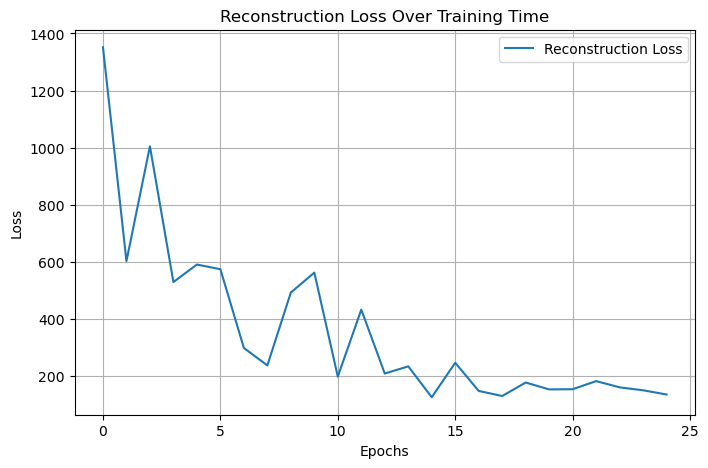

In [8]:
### TODO: make plot of reconstruction loss (y-axis) over training time (x-axis)
plt.figure(figsize=(8, 5))
plt.plot(range(len(loss_values)), loss_values, label='Reconstruction Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Reconstruction Loss Over Training Time')
plt.legend()
plt.grid(True)
plt.show()

## Evaluation

### Question 5: Reconstruct whole image (20 points)

For this part, reconstruct the image using your model's outputs, at each coordinate.
You can use our scaffolding code, or write your own.
For this part, we are just grading the image plot, where you should plot the original image side-by-side with the reconstruction, as shown in this example.

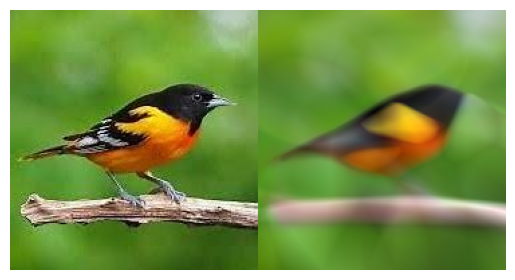

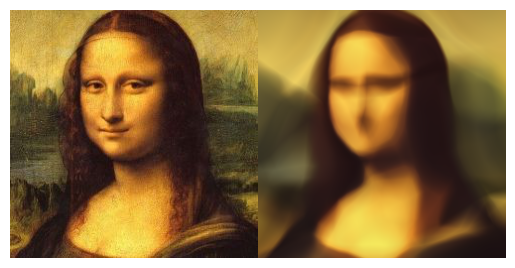

In [9]:
pred_image_shape = (3, 250, 250)
pred_image = torch.zeros(*pred_image_shape)

for x in range(0,250):
  for y in range(0,250):
    x_normalized = torch.tensor(x, dtype=torch.float) / 250
    y_normalized = torch.tensor(y, dtype=torch.float) / 250
    coord = torch.stack((x_normalized, y_normalized), dim=-1)
    prediction = net(coord)
    pred_image[:, y, x] = prediction[:]

joint_image = torch.cat([image, pred_image], dim=2)
plt.imshow(joint_image.detach().permute(1, 2, 0).numpy().astype(np.uint8))
plt.axis('off')
plt.show()
plt.close()

### Question 6: Compute PSNR (10 points)

For this part, print the PSNR for your reconstruction vs. the original image. Feel free to use any libraries, or implement it from scratch.

In [10]:
import math

### TODO: compute and print PSNR between reconstructed (predicted) and ground truth images
mse = torch.mean((image - pred_image) ** 2)

# Calculate the PSNR
max_intensity = 255.0  # Assuming pixel values are in the range [0, 1]
psnr = 20 * math.log10(max_intensity) - 10 * math.log10(mse)

# Print the PSNR value
print(f"Peak Signal-to-Noise Ratio (PSNR): {psnr:.2f} dB")

Peak Signal-to-Noise Ratio (PSNR): 25.83 dB


### Question 7: Outpainting (10 points)

INR is a continuous image representation. What happens if your input coordinates don't correspond to real pixels? Try it out and show the result!

For this part, have your model predict 20 pixels in all directions that are outside the boundaries of the original image, and show the resulting image below. Also plot a box around the region corresponding to the original image, for clarity.

We show an example below.

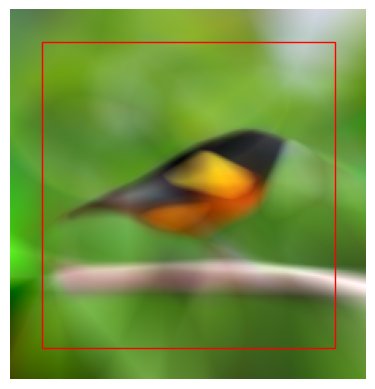

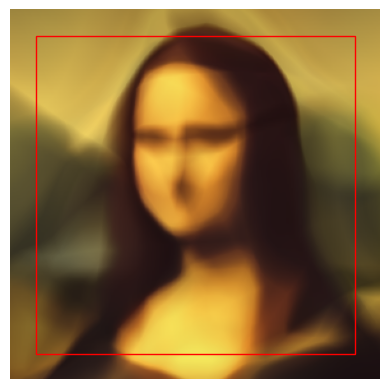

In [11]:
import matplotlib.patches as patches

### TODO: 6-10 lines of code to generate outpainted image
# outpainted_image =

input_coords = []
for x in range(-20, image.shape[2] + 20):
    for y in range(-20, image.shape[1] + 20):
        input_coords.append([x / (image.shape[2] + 19), y / (image.shape[1] + 19)])

input_coords = torch.tensor(input_coords)
pred_outpaint = net(input_coords)
pred_outpaint = pred_outpaint.view(image.shape[1] + 40, image.shape[2] + 40, image.shape[0])

fig, ax = plt.subplots()
ax.imshow(pred_outpaint.detach().permute(1,0,2).numpy().astype(np.uint8))
rect = patches.Rectangle((20, 20), dataset.w, dataset.h, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)
plt.axis('off')
plt.show()
plt.close()

## Bonus

The main idea of the bonus is to do something to make your model better than the one we walk you through in the assignment. Be creative! You can receive a maximum of 20 points for this portion.

### Question 8: Improve the Reconstruction Quality of the System (20 points, optional)

For this question, you must do two things:

1. Make a non-trivial change from what we guided you through in the assignment.
2. Prove that the change improves reconstruction quality. Compare your new output/PSNR to the old output/PSNR (plot the images, print the PSNR).

If you can't think of your own idea, revisit some of the literature from Shishira's guest lectures. For example, instead of taking raw coordinate inputs, you could try using positional encodings.

/Users/omkar/anaconda3/envs/pytorch3d/lib/python3.9/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1656352453927/work/aten/src/ATen/native/TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


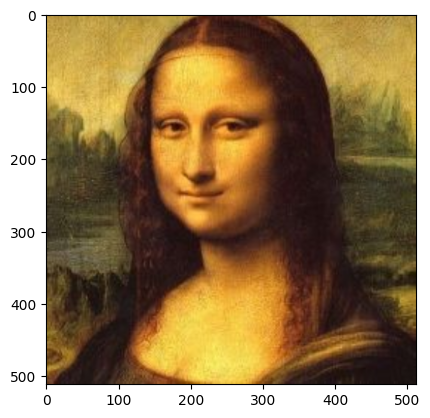

In [3]:
import cv2
import torch
from torch.utils.data import Dataset


def create_grid(h, w, device="cpu"):
    grid_y, grid_x = torch.meshgrid([torch.linspace(0, 1, steps=h),
                                     torch.linspace(0, 1, steps=w)])
    grid = torch.stack([grid_y, grid_x], dim=-1)
    return grid.to(device)


class ImageDataset(Dataset):

    def __init__(self, image_path, img_dim):
        self.img_dim = (img_dim, img_dim) if type(img_dim) == int else img_dim
        image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
        h, w, c = image.shape
        left_w = int((w - h) / 2)

        image = image[:, left_w:left_w + h]
        image = cv2.resize(image, self.img_dim, interpolation=cv2.INTER_LINEAR)
        self.img = image

    def __getitem__(self, idx):
        image = self.img / 255

        grid = create_grid(*self.img_dim[::-1])

        return grid, torch.tensor(image, dtype=torch.float32)

    def __len__(self):
        return 1


if __name__ == '__main__':
    import matplotlib.pyplot as plt
    import numpy as np
    import torchvision

    ds = ImageDataset("data/mona.jpeg", 512)
    grid, image = ds[0]
    torchvision.utils.save_image(image.permute(2, 0, 1), "data/demo.jpg")
    image = image.numpy() * 255
    plt.imshow(image.astype(np.uint8))
    plt.show()

train iter:   0%|          | 0/250 [00:00<?, ?it/s]

---[steps: 0]: train loss: 0.100713


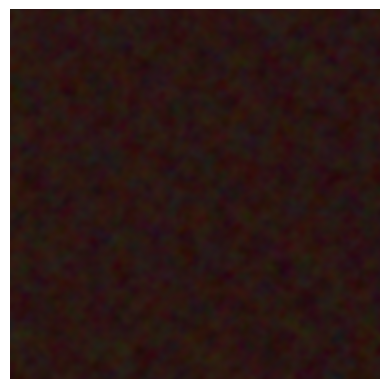

train iter:   0%|          | 1/250 [00:00<03:21,  1.24it/s]

---[steps: 0]: valid loss: 0.114265


train iter:   1%|          | 2/250 [00:01<02:02,  2.03it/s]

---[steps: 1]: train loss: 0.057180


train iter:   1%|          | 3/250 [00:01<01:31,  2.69it/s]

---[steps: 2]: train loss: 0.040280


train iter:   2%|▏         | 4/250 [00:01<01:17,  3.18it/s]

---[steps: 3]: train loss: 0.033206


train iter:   2%|▏         | 5/250 [00:01<01:10,  3.47it/s]

---[steps: 4]: train loss: 0.029894


train iter:   2%|▏         | 6/250 [00:02<01:05,  3.71it/s]

---[steps: 5]: train loss: 0.027968


train iter:   3%|▎         | 7/250 [00:02<01:02,  3.90it/s]

---[steps: 6]: train loss: 0.026581


train iter:   3%|▎         | 8/250 [00:02<00:59,  4.07it/s]

---[steps: 7]: train loss: 0.025436


train iter:   4%|▎         | 9/250 [00:02<00:57,  4.19it/s]

---[steps: 8]: train loss: 0.024483


train iter:   4%|▍         | 10/250 [00:02<00:56,  4.26it/s]

---[steps: 9]: train loss: 0.023648


train iter:   4%|▍         | 11/250 [00:03<00:55,  4.31it/s]

---[steps: 10]: train loss: 0.022790


train iter:   5%|▍         | 12/250 [00:03<00:54,  4.35it/s]

---[steps: 11]: train loss: 0.021761


train iter:   5%|▌         | 13/250 [00:03<00:54,  4.36it/s]

---[steps: 12]: train loss: 0.020448


train iter:   6%|▌         | 14/250 [00:03<00:54,  4.37it/s]

---[steps: 13]: train loss: 0.018892


train iter:   6%|▌         | 15/250 [00:04<00:53,  4.38it/s]

---[steps: 14]: train loss: 0.017294


train iter:   6%|▋         | 16/250 [00:04<00:53,  4.38it/s]

---[steps: 15]: train loss: 0.015681


train iter:   7%|▋         | 17/250 [00:04<00:53,  4.38it/s]

---[steps: 16]: train loss: 0.014202


train iter:   7%|▋         | 18/250 [00:04<00:53,  4.37it/s]

---[steps: 17]: train loss: 0.012887


train iter:   8%|▊         | 19/250 [00:04<00:53,  4.33it/s]

---[steps: 18]: train loss: 0.011633


train iter:   8%|▊         | 20/250 [00:05<00:54,  4.24it/s]

---[steps: 19]: train loss: 0.010452


train iter:   8%|▊         | 21/250 [00:05<00:53,  4.26it/s]

---[steps: 20]: train loss: 0.009300


train iter:   9%|▉         | 22/250 [00:05<00:53,  4.29it/s]

---[steps: 21]: train loss: 0.008292


train iter:   9%|▉         | 23/250 [00:05<00:53,  4.28it/s]

---[steps: 22]: train loss: 0.007388


train iter:  10%|▉         | 24/250 [00:06<00:52,  4.27it/s]

---[steps: 23]: train loss: 0.006614


train iter:  10%|█         | 25/250 [00:06<00:52,  4.28it/s]

---[steps: 24]: train loss: 0.005900
---[steps: 25]: train loss: 0.005269


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


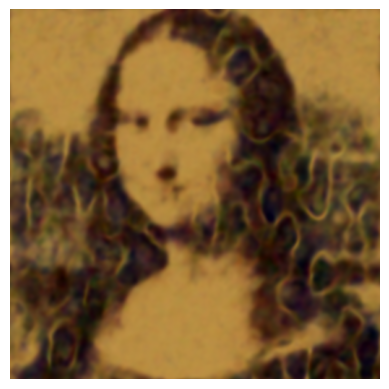

train iter:  10%|█         | 26/250 [00:07<01:25,  2.62it/s]

---[steps: 25]: valid loss: 0.009363


train iter:  11%|█         | 27/250 [00:07<01:16,  2.93it/s]

---[steps: 26]: train loss: 0.004682


train iter:  11%|█         | 28/250 [00:07<01:08,  3.25it/s]

---[steps: 27]: train loss: 0.004145


train iter:  12%|█▏        | 29/250 [00:07<01:03,  3.51it/s]

---[steps: 28]: train loss: 0.003663


train iter:  12%|█▏        | 30/250 [00:08<00:59,  3.68it/s]

---[steps: 29]: train loss: 0.003230


train iter:  12%|█▏        | 31/250 [00:08<00:59,  3.70it/s]

---[steps: 30]: train loss: 0.002864


train iter:  13%|█▎        | 32/250 [00:08<00:56,  3.88it/s]

---[steps: 31]: train loss: 0.002542


train iter:  13%|█▎        | 33/250 [00:08<00:54,  3.98it/s]

---[steps: 32]: train loss: 0.002269


train iter:  14%|█▎        | 34/250 [00:09<00:53,  4.01it/s]

---[steps: 33]: train loss: 0.002032


train iter:  14%|█▍        | 35/250 [00:09<00:52,  4.08it/s]

---[steps: 34]: train loss: 0.001829


train iter:  14%|█▍        | 36/250 [00:09<00:52,  4.08it/s]

---[steps: 35]: train loss: 0.001659


train iter:  15%|█▍        | 37/250 [00:09<00:51,  4.16it/s]

---[steps: 36]: train loss: 0.001509


train iter:  15%|█▌        | 38/250 [00:09<00:50,  4.19it/s]

---[steps: 37]: train loss: 0.001384


train iter:  16%|█▌        | 39/250 [00:10<00:50,  4.22it/s]

---[steps: 38]: train loss: 0.001274


train iter:  16%|█▌        | 40/250 [00:10<00:49,  4.26it/s]

---[steps: 39]: train loss: 0.001177


train iter:  16%|█▋        | 41/250 [00:10<00:49,  4.24it/s]

---[steps: 40]: train loss: 0.001094


train iter:  17%|█▋        | 42/250 [00:10<00:49,  4.21it/s]

---[steps: 41]: train loss: 0.001016


train iter:  17%|█▋        | 43/250 [00:11<00:49,  4.22it/s]

---[steps: 42]: train loss: 0.000950


train iter:  18%|█▊        | 44/250 [00:11<00:48,  4.25it/s]

---[steps: 43]: train loss: 0.000888


train iter:  18%|█▊        | 45/250 [00:11<00:48,  4.19it/s]

---[steps: 44]: train loss: 0.000832


train iter:  18%|█▊        | 46/250 [00:11<00:48,  4.17it/s]

---[steps: 45]: train loss: 0.000782


train iter:  19%|█▉        | 47/250 [00:12<00:48,  4.15it/s]

---[steps: 46]: train loss: 0.000734


train iter:  19%|█▉        | 48/250 [00:12<00:48,  4.14it/s]

---[steps: 47]: train loss: 0.000693


train iter:  20%|█▉        | 49/250 [00:12<00:49,  4.02it/s]

---[steps: 48]: train loss: 0.000654


train iter:  20%|██        | 50/250 [00:12<00:48,  4.11it/s]

---[steps: 49]: train loss: 0.000620
---[steps: 50]: train loss: 0.000589


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


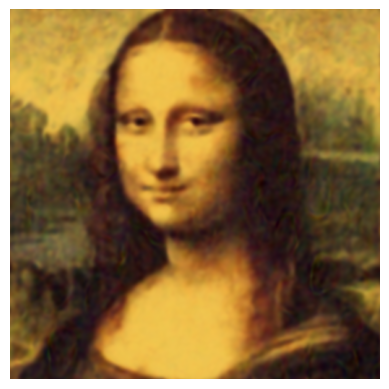

train iter:  20%|██        | 51/250 [00:13<01:17,  2.56it/s]

---[steps: 50]: valid loss: 0.001117


train iter:  21%|██        | 52/250 [00:13<01:08,  2.87it/s]

---[steps: 51]: train loss: 0.000559


train iter:  21%|██        | 53/250 [00:14<01:03,  3.11it/s]

---[steps: 52]: train loss: 0.000532


train iter:  22%|██▏       | 54/250 [00:14<00:58,  3.35it/s]

---[steps: 53]: train loss: 0.000506


train iter:  22%|██▏       | 55/250 [00:14<00:55,  3.53it/s]

---[steps: 54]: train loss: 0.000484


train iter:  22%|██▏       | 56/250 [00:14<00:52,  3.73it/s]

---[steps: 55]: train loss: 0.000463


train iter:  23%|██▎       | 57/250 [00:15<00:50,  3.82it/s]

---[steps: 56]: train loss: 0.000445


train iter:  23%|██▎       | 58/250 [00:15<00:49,  3.90it/s]

---[steps: 57]: train loss: 0.000427


train iter:  24%|██▎       | 59/250 [00:15<00:48,  3.97it/s]

---[steps: 58]: train loss: 0.000411


train iter:  24%|██▍       | 60/250 [00:15<00:46,  4.05it/s]

---[steps: 59]: train loss: 0.000395


train iter:  24%|██▍       | 61/250 [00:16<00:46,  4.07it/s]

---[steps: 60]: train loss: 0.000381


train iter:  25%|██▍       | 62/250 [00:16<00:45,  4.13it/s]

---[steps: 61]: train loss: 0.000367


train iter:  25%|██▌       | 63/250 [00:16<00:46,  4.02it/s]

---[steps: 62]: train loss: 0.000355


train iter:  26%|██▌       | 64/250 [00:16<00:47,  3.95it/s]

---[steps: 63]: train loss: 0.000344


train iter:  26%|██▌       | 65/250 [00:17<00:46,  3.95it/s]

---[steps: 64]: train loss: 0.000333


train iter:  26%|██▋       | 66/250 [00:17<00:46,  3.97it/s]

---[steps: 65]: train loss: 0.000324


train iter:  27%|██▋       | 67/250 [00:17<00:45,  4.02it/s]

---[steps: 66]: train loss: 0.000315


train iter:  27%|██▋       | 68/250 [00:17<00:44,  4.10it/s]

---[steps: 67]: train loss: 0.000307


train iter:  28%|██▊       | 69/250 [00:18<00:44,  4.10it/s]

---[steps: 68]: train loss: 0.000299


train iter:  28%|██▊       | 70/250 [00:18<00:44,  4.02it/s]

---[steps: 69]: train loss: 0.000292


train iter:  28%|██▊       | 71/250 [00:18<00:44,  4.00it/s]

---[steps: 70]: train loss: 0.000285


train iter:  29%|██▉       | 72/250 [00:18<00:44,  4.02it/s]

---[steps: 71]: train loss: 0.000279


train iter:  29%|██▉       | 73/250 [00:19<00:43,  4.03it/s]

---[steps: 72]: train loss: 0.000273


train iter:  30%|██▉       | 74/250 [00:19<00:44,  3.92it/s]

---[steps: 73]: train loss: 0.000268


train iter:  30%|███       | 75/250 [00:19<00:44,  3.97it/s]

---[steps: 74]: train loss: 0.000263
---[steps: 75]: train loss: 0.000258


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


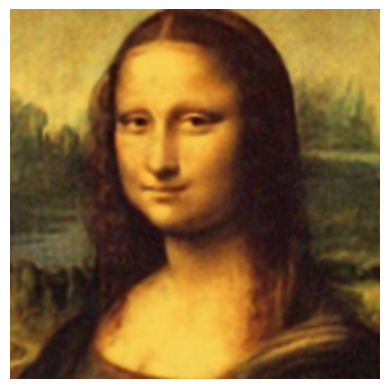

train iter:  30%|███       | 76/250 [00:20<01:09,  2.52it/s]

---[steps: 75]: valid loss: 0.000507


train iter:  31%|███       | 77/250 [00:20<01:01,  2.80it/s]

---[steps: 76]: train loss: 0.000253


train iter:  31%|███       | 78/250 [00:20<00:54,  3.14it/s]

---[steps: 77]: train loss: 0.000249


train iter:  32%|███▏      | 79/250 [00:21<00:50,  3.41it/s]

---[steps: 78]: train loss: 0.000245


train iter:  32%|███▏      | 80/250 [00:21<00:46,  3.62it/s]

---[steps: 79]: train loss: 0.000241


train iter:  32%|███▏      | 81/250 [00:21<00:44,  3.77it/s]

---[steps: 80]: train loss: 0.000238


train iter:  33%|███▎      | 82/250 [00:21<00:43,  3.91it/s]

---[steps: 81]: train loss: 0.000234


train iter:  33%|███▎      | 83/250 [00:21<00:41,  4.03it/s]

---[steps: 82]: train loss: 0.000231


train iter:  34%|███▎      | 84/250 [00:22<00:40,  4.07it/s]

---[steps: 83]: train loss: 0.000228


train iter:  34%|███▍      | 85/250 [00:22<00:40,  4.04it/s]

---[steps: 84]: train loss: 0.000225


train iter:  34%|███▍      | 86/250 [00:22<00:40,  4.07it/s]

---[steps: 85]: train loss: 0.000222


train iter:  35%|███▍      | 87/250 [00:22<00:39,  4.14it/s]

---[steps: 86]: train loss: 0.000219


train iter:  35%|███▌      | 88/250 [00:23<00:38,  4.17it/s]

---[steps: 87]: train loss: 0.000217


train iter:  36%|███▌      | 89/250 [00:23<00:39,  4.12it/s]

---[steps: 88]: train loss: 0.000214


train iter:  36%|███▌      | 90/250 [00:23<00:38,  4.17it/s]

---[steps: 89]: train loss: 0.000212


train iter:  36%|███▋      | 91/250 [00:23<00:38,  4.12it/s]

---[steps: 90]: train loss: 0.000209


train iter:  37%|███▋      | 92/250 [00:24<00:38,  4.15it/s]

---[steps: 91]: train loss: 0.000207


train iter:  37%|███▋      | 93/250 [00:24<00:37,  4.14it/s]

---[steps: 92]: train loss: 0.000205


train iter:  38%|███▊      | 94/250 [00:24<00:37,  4.17it/s]

---[steps: 93]: train loss: 0.000203


train iter:  38%|███▊      | 95/250 [00:24<00:37,  4.19it/s]

---[steps: 94]: train loss: 0.000201


train iter:  38%|███▊      | 96/250 [00:25<00:36,  4.18it/s]

---[steps: 95]: train loss: 0.000199


train iter:  39%|███▉      | 97/250 [00:25<00:36,  4.17it/s]

---[steps: 96]: train loss: 0.000197


train iter:  39%|███▉      | 98/250 [00:25<00:35,  4.23it/s]

---[steps: 97]: train loss: 0.000196


train iter:  40%|███▉      | 99/250 [00:25<00:35,  4.22it/s]

---[steps: 98]: train loss: 0.000194


train iter:  40%|████      | 100/250 [00:26<00:35,  4.19it/s]

---[steps: 99]: train loss: 0.000192
---[steps: 100]: train loss: 0.000191


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


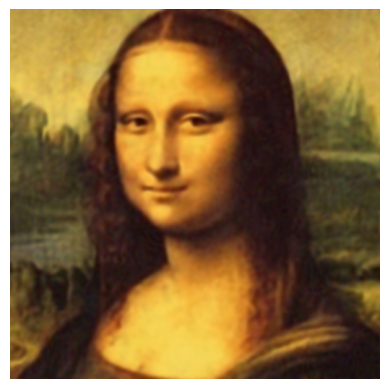

train iter:  40%|████      | 101/250 [00:26<00:58,  2.56it/s]

---[steps: 100]: valid loss: 0.000379


train iter:  41%|████      | 102/250 [00:27<00:51,  2.87it/s]

---[steps: 101]: train loss: 0.000189


train iter:  41%|████      | 103/250 [00:27<00:46,  3.18it/s]

---[steps: 102]: train loss: 0.000188


train iter:  42%|████▏     | 104/250 [00:27<00:42,  3.44it/s]

---[steps: 103]: train loss: 0.000186


train iter:  42%|████▏     | 105/250 [00:27<00:39,  3.65it/s]

---[steps: 104]: train loss: 0.000185


train iter:  42%|████▏     | 106/250 [00:27<00:37,  3.79it/s]

---[steps: 105]: train loss: 0.000183


train iter:  43%|████▎     | 107/250 [00:28<00:36,  3.92it/s]

---[steps: 106]: train loss: 0.000182


train iter:  43%|████▎     | 108/250 [00:28<00:35,  3.97it/s]

---[steps: 107]: train loss: 0.000181


train iter:  44%|████▎     | 109/250 [00:28<00:35,  4.00it/s]

---[steps: 108]: train loss: 0.000180


train iter:  44%|████▍     | 110/250 [00:28<00:34,  4.07it/s]

---[steps: 109]: train loss: 0.000178


train iter:  44%|████▍     | 111/250 [00:29<00:33,  4.09it/s]

---[steps: 110]: train loss: 0.000177


train iter:  45%|████▍     | 112/250 [00:29<00:33,  4.09it/s]

---[steps: 111]: train loss: 0.000176


train iter:  45%|████▌     | 113/250 [00:29<00:33,  4.07it/s]

---[steps: 112]: train loss: 0.000175


train iter:  46%|████▌     | 114/250 [00:29<00:33,  4.09it/s]

---[steps: 113]: train loss: 0.000174


train iter:  46%|████▌     | 115/250 [00:30<00:33,  4.09it/s]

---[steps: 114]: train loss: 0.000173


train iter:  46%|████▋     | 116/250 [00:30<00:32,  4.14it/s]

---[steps: 115]: train loss: 0.000172


train iter:  47%|████▋     | 117/250 [00:30<00:31,  4.16it/s]

---[steps: 116]: train loss: 0.000170


train iter:  47%|████▋     | 118/250 [00:30<00:32,  4.05it/s]

---[steps: 117]: train loss: 0.000169


train iter:  48%|████▊     | 119/250 [00:31<00:31,  4.10it/s]

---[steps: 118]: train loss: 0.000168


train iter:  48%|████▊     | 120/250 [00:31<00:31,  4.16it/s]

---[steps: 119]: train loss: 0.000167


train iter:  48%|████▊     | 121/250 [00:31<00:30,  4.19it/s]

---[steps: 120]: train loss: 0.000167


train iter:  49%|████▉     | 122/250 [00:31<00:30,  4.19it/s]

---[steps: 121]: train loss: 0.000166


train iter:  49%|████▉     | 123/250 [00:32<00:30,  4.18it/s]

---[steps: 122]: train loss: 0.000165


train iter:  50%|████▉     | 124/250 [00:32<00:29,  4.21it/s]

---[steps: 123]: train loss: 0.000164


train iter:  50%|█████     | 125/250 [00:32<00:29,  4.23it/s]

---[steps: 124]: train loss: 0.000163
---[steps: 125]: train loss: 0.000162


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


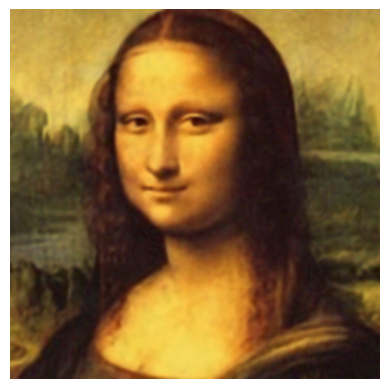

train iter:  50%|█████     | 126/250 [00:33<00:47,  2.58it/s]

---[steps: 125]: valid loss: 0.000324


train iter:  51%|█████     | 127/250 [00:33<00:42,  2.89it/s]

---[steps: 126]: train loss: 0.000161


train iter:  51%|█████     | 128/250 [00:33<00:38,  3.17it/s]

---[steps: 127]: train loss: 0.000160


train iter:  52%|█████▏    | 129/250 [00:33<00:35,  3.44it/s]

---[steps: 128]: train loss: 0.000159


train iter:  52%|█████▏    | 130/250 [00:34<00:32,  3.64it/s]

---[steps: 129]: train loss: 0.000159


train iter:  52%|█████▏    | 131/250 [00:34<00:31,  3.78it/s]

---[steps: 130]: train loss: 0.000158


train iter:  53%|█████▎    | 132/250 [00:34<00:30,  3.89it/s]

---[steps: 131]: train loss: 0.000157


train iter:  53%|█████▎    | 133/250 [00:34<00:29,  4.00it/s]

---[steps: 132]: train loss: 0.000156


train iter:  54%|█████▎    | 134/250 [00:35<00:29,  3.99it/s]

---[steps: 133]: train loss: 0.000156


train iter:  54%|█████▍    | 135/250 [00:35<00:28,  4.03it/s]

---[steps: 134]: train loss: 0.000155


train iter:  54%|█████▍    | 136/250 [00:35<00:27,  4.08it/s]

---[steps: 135]: train loss: 0.000154


train iter:  55%|█████▍    | 137/250 [00:35<00:27,  4.13it/s]

---[steps: 136]: train loss: 0.000153


train iter:  55%|█████▌    | 138/250 [00:36<00:26,  4.16it/s]

---[steps: 137]: train loss: 0.000153


train iter:  56%|█████▌    | 139/250 [00:36<00:26,  4.19it/s]

---[steps: 138]: train loss: 0.000152


train iter:  56%|█████▌    | 140/250 [00:36<00:26,  4.20it/s]

---[steps: 139]: train loss: 0.000151


train iter:  56%|█████▋    | 141/250 [00:36<00:26,  4.17it/s]

---[steps: 140]: train loss: 0.000151


train iter:  57%|█████▋    | 142/250 [00:37<00:25,  4.17it/s]

---[steps: 141]: train loss: 0.000150


train iter:  57%|█████▋    | 143/250 [00:37<00:25,  4.15it/s]

---[steps: 142]: train loss: 0.000149


train iter:  58%|█████▊    | 144/250 [00:37<00:25,  4.15it/s]

---[steps: 143]: train loss: 0.000149


train iter:  58%|█████▊    | 145/250 [00:37<00:25,  4.13it/s]

---[steps: 144]: train loss: 0.000148


train iter:  58%|█████▊    | 146/250 [00:38<00:25,  4.15it/s]

---[steps: 145]: train loss: 0.000147


train iter:  59%|█████▉    | 147/250 [00:38<00:25,  4.09it/s]

---[steps: 146]: train loss: 0.000147


train iter:  59%|█████▉    | 148/250 [00:38<00:25,  4.06it/s]

---[steps: 147]: train loss: 0.000146


train iter:  60%|█████▉    | 149/250 [00:38<00:24,  4.12it/s]

---[steps: 148]: train loss: 0.000146


train iter:  60%|██████    | 150/250 [00:39<00:24,  4.10it/s]

---[steps: 149]: train loss: 0.000145
---[steps: 150]: train loss: 0.000144


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


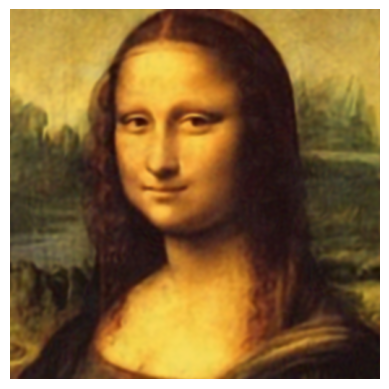

train iter:  60%|██████    | 151/250 [00:39<00:38,  2.55it/s]

---[steps: 150]: valid loss: 0.000290


train iter:  61%|██████    | 152/250 [00:40<00:34,  2.84it/s]

---[steps: 151]: train loss: 0.000144


train iter:  61%|██████    | 153/250 [00:40<00:30,  3.13it/s]

---[steps: 152]: train loss: 0.000143


train iter:  62%|██████▏   | 154/250 [00:40<00:28,  3.37it/s]

---[steps: 153]: train loss: 0.000143


train iter:  62%|██████▏   | 155/250 [00:40<00:26,  3.58it/s]

---[steps: 154]: train loss: 0.000142


train iter:  62%|██████▏   | 156/250 [00:41<00:24,  3.77it/s]

---[steps: 155]: train loss: 0.000141


train iter:  63%|██████▎   | 157/250 [00:41<00:23,  3.88it/s]

---[steps: 156]: train loss: 0.000141


train iter:  63%|██████▎   | 158/250 [00:41<00:23,  3.94it/s]

---[steps: 157]: train loss: 0.000140


train iter:  64%|██████▎   | 159/250 [00:41<00:22,  4.02it/s]

---[steps: 158]: train loss: 0.000140


train iter:  64%|██████▍   | 160/250 [00:41<00:22,  4.07it/s]

---[steps: 159]: train loss: 0.000139


train iter:  64%|██████▍   | 161/250 [00:42<00:21,  4.06it/s]

---[steps: 160]: train loss: 0.000139


train iter:  65%|██████▍   | 162/250 [00:42<00:21,  4.11it/s]

---[steps: 161]: train loss: 0.000138


train iter:  65%|██████▌   | 163/250 [00:42<00:21,  4.11it/s]

---[steps: 162]: train loss: 0.000138


train iter:  66%|██████▌   | 164/250 [00:42<00:20,  4.14it/s]

---[steps: 163]: train loss: 0.000137


train iter:  66%|██████▌   | 165/250 [00:43<00:20,  4.12it/s]

---[steps: 164]: train loss: 0.000137


train iter:  66%|██████▋   | 166/250 [00:43<00:20,  4.10it/s]

---[steps: 165]: train loss: 0.000136


train iter:  67%|██████▋   | 167/250 [00:43<00:20,  4.13it/s]

---[steps: 166]: train loss: 0.000136


train iter:  67%|██████▋   | 168/250 [00:43<00:19,  4.16it/s]

---[steps: 167]: train loss: 0.000135


train iter:  68%|██████▊   | 169/250 [00:44<00:19,  4.15it/s]

---[steps: 168]: train loss: 0.000135


train iter:  68%|██████▊   | 170/250 [00:44<00:19,  4.16it/s]

---[steps: 169]: train loss: 0.000134


train iter:  68%|██████▊   | 171/250 [00:44<00:19,  4.11it/s]

---[steps: 170]: train loss: 0.000134


train iter:  69%|██████▉   | 172/250 [00:44<00:18,  4.12it/s]

---[steps: 171]: train loss: 0.000133


train iter:  69%|██████▉   | 173/250 [00:45<00:18,  4.12it/s]

---[steps: 172]: train loss: 0.000133


train iter:  70%|██████▉   | 174/250 [00:45<00:18,  4.13it/s]

---[steps: 173]: train loss: 0.000133


train iter:  70%|███████   | 175/250 [00:45<00:18,  4.12it/s]

---[steps: 174]: train loss: 0.000132
---[steps: 175]: train loss: 0.000132


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


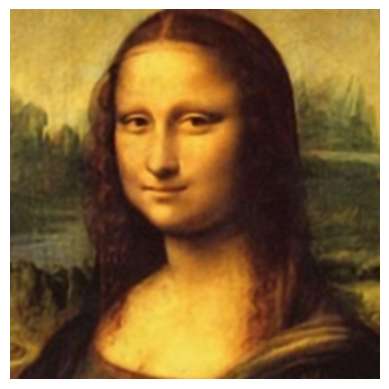

train iter:  70%|███████   | 176/250 [00:46<00:29,  2.51it/s]

---[steps: 175]: valid loss: 0.000266


train iter:  71%|███████   | 177/250 [00:46<00:25,  2.82it/s]

---[steps: 176]: train loss: 0.000131


train iter:  71%|███████   | 178/250 [00:46<00:23,  3.08it/s]

---[steps: 177]: train loss: 0.000131


train iter:  72%|███████▏  | 179/250 [00:47<00:21,  3.32it/s]

---[steps: 178]: train loss: 0.000130


train iter:  72%|███████▏  | 180/250 [00:47<00:19,  3.54it/s]

---[steps: 179]: train loss: 0.000130


train iter:  72%|███████▏  | 181/250 [00:47<00:18,  3.69it/s]

---[steps: 180]: train loss: 0.000129


train iter:  73%|███████▎  | 182/250 [00:47<00:17,  3.82it/s]

---[steps: 181]: train loss: 0.000129


train iter:  73%|███████▎  | 183/250 [00:48<00:17,  3.92it/s]

---[steps: 182]: train loss: 0.000129


train iter:  74%|███████▎  | 184/250 [00:48<00:16,  3.94it/s]

---[steps: 183]: train loss: 0.000128


train iter:  74%|███████▍  | 185/250 [00:48<00:16,  3.98it/s]

---[steps: 184]: train loss: 0.000128


train iter:  74%|███████▍  | 186/250 [00:48<00:16,  3.96it/s]

---[steps: 185]: train loss: 0.000127


train iter:  75%|███████▍  | 187/250 [00:49<00:15,  3.97it/s]

---[steps: 186]: train loss: 0.000127


train iter:  75%|███████▌  | 188/250 [00:49<00:15,  4.02it/s]

---[steps: 187]: train loss: 0.000127


train iter:  76%|███████▌  | 189/250 [00:49<00:15,  4.01it/s]

---[steps: 188]: train loss: 0.000126


train iter:  76%|███████▌  | 190/250 [00:49<00:14,  4.02it/s]

---[steps: 189]: train loss: 0.000126


train iter:  76%|███████▋  | 191/250 [00:50<00:14,  3.97it/s]

---[steps: 190]: train loss: 0.000125


train iter:  77%|███████▋  | 192/250 [00:50<00:14,  4.04it/s]

---[steps: 191]: train loss: 0.000125


train iter:  77%|███████▋  | 193/250 [00:50<00:14,  4.06it/s]

---[steps: 192]: train loss: 0.000125


train iter:  78%|███████▊  | 194/250 [00:50<00:13,  4.01it/s]

---[steps: 193]: train loss: 0.000124


train iter:  78%|███████▊  | 195/250 [00:51<00:13,  4.02it/s]

---[steps: 194]: train loss: 0.000124


train iter:  78%|███████▊  | 196/250 [00:51<00:13,  4.05it/s]

---[steps: 195]: train loss: 0.000124


train iter:  79%|███████▉  | 197/250 [00:51<00:13,  4.02it/s]

---[steps: 196]: train loss: 0.000123


train iter:  79%|███████▉  | 198/250 [00:51<00:12,  4.05it/s]

---[steps: 197]: train loss: 0.000123


train iter:  80%|███████▉  | 199/250 [00:52<00:12,  4.03it/s]

---[steps: 198]: train loss: 0.000122


train iter:  80%|████████  | 200/250 [00:52<00:12,  3.97it/s]

---[steps: 199]: train loss: 0.000122
---[steps: 200]: train loss: 0.000122


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


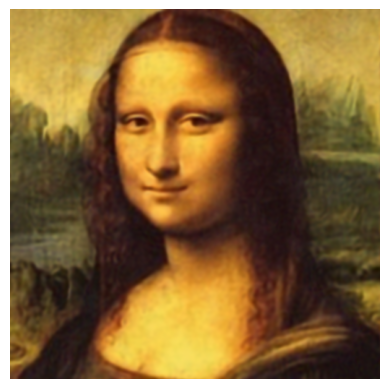

train iter:  80%|████████  | 201/250 [00:53<00:20,  2.45it/s]

---[steps: 200]: valid loss: 0.000247


train iter:  81%|████████  | 202/250 [00:53<00:17,  2.74it/s]

---[steps: 201]: train loss: 0.000121


train iter:  81%|████████  | 203/250 [00:53<00:15,  2.98it/s]

---[steps: 202]: train loss: 0.000121


train iter:  82%|████████▏ | 204/250 [00:53<00:14,  3.24it/s]

---[steps: 203]: train loss: 0.000121


train iter:  82%|████████▏ | 205/250 [00:54<00:12,  3.47it/s]

---[steps: 204]: train loss: 0.000120


train iter:  82%|████████▏ | 206/250 [00:54<00:12,  3.62it/s]

---[steps: 205]: train loss: 0.000120


train iter:  83%|████████▎ | 207/250 [00:54<00:11,  3.76it/s]

---[steps: 206]: train loss: 0.000120


train iter:  83%|████████▎ | 208/250 [00:54<00:10,  3.84it/s]

---[steps: 207]: train loss: 0.000119


train iter:  84%|████████▎ | 209/250 [00:55<00:10,  3.93it/s]

---[steps: 208]: train loss: 0.000119


train iter:  84%|████████▍ | 210/250 [00:55<00:10,  3.96it/s]

---[steps: 209]: train loss: 0.000119


train iter:  84%|████████▍ | 211/250 [00:55<00:09,  4.05it/s]

---[steps: 210]: train loss: 0.000118


train iter:  85%|████████▍ | 212/250 [00:55<00:09,  4.05it/s]

---[steps: 211]: train loss: 0.000118


train iter:  85%|████████▌ | 213/250 [00:56<00:09,  4.11it/s]

---[steps: 212]: train loss: 0.000118


train iter:  86%|████████▌ | 214/250 [00:56<00:08,  4.09it/s]

---[steps: 213]: train loss: 0.000117


train iter:  86%|████████▌ | 215/250 [00:56<00:08,  4.15it/s]

---[steps: 214]: train loss: 0.000117


train iter:  86%|████████▋ | 216/250 [00:56<00:08,  4.14it/s]

---[steps: 215]: train loss: 0.000117


train iter:  87%|████████▋ | 217/250 [00:57<00:08,  4.09it/s]

---[steps: 216]: train loss: 0.000116


train iter:  87%|████████▋ | 218/250 [00:57<00:07,  4.03it/s]

---[steps: 217]: train loss: 0.000116


train iter:  88%|████████▊ | 219/250 [00:57<00:07,  4.10it/s]

---[steps: 218]: train loss: 0.000116


train iter:  88%|████████▊ | 220/250 [00:57<00:07,  4.10it/s]

---[steps: 219]: train loss: 0.000116


train iter:  88%|████████▊ | 221/250 [00:57<00:07,  4.11it/s]

---[steps: 220]: train loss: 0.000115


train iter:  89%|████████▉ | 222/250 [00:58<00:06,  4.12it/s]

---[steps: 221]: train loss: 0.000115


train iter:  89%|████████▉ | 223/250 [00:58<00:06,  4.15it/s]

---[steps: 222]: train loss: 0.000115


train iter:  90%|████████▉ | 224/250 [00:58<00:06,  4.14it/s]

---[steps: 223]: train loss: 0.000114


train iter:  90%|█████████ | 225/250 [00:58<00:06,  4.15it/s]

---[steps: 224]: train loss: 0.000114
---[steps: 225]: train loss: 0.000114


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


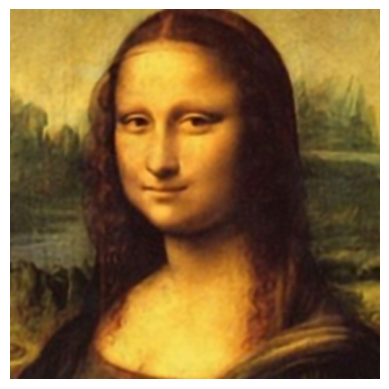

train iter:  90%|█████████ | 226/250 [00:59<00:09,  2.50it/s]

---[steps: 225]: valid loss: 0.000231


train iter:  91%|█████████ | 227/250 [01:00<00:08,  2.76it/s]

---[steps: 226]: train loss: 0.000113


train iter:  91%|█████████ | 228/250 [01:00<00:07,  3.09it/s]

---[steps: 227]: train loss: 0.000113


train iter:  92%|█████████▏| 229/250 [01:00<00:06,  3.35it/s]

---[steps: 228]: train loss: 0.000113


train iter:  92%|█████████▏| 230/250 [01:00<00:05,  3.52it/s]

---[steps: 229]: train loss: 0.000113


train iter:  92%|█████████▏| 231/250 [01:00<00:05,  3.71it/s]

---[steps: 230]: train loss: 0.000112


train iter:  93%|█████████▎| 232/250 [01:01<00:04,  3.80it/s]

---[steps: 231]: train loss: 0.000112


train iter:  93%|█████████▎| 233/250 [01:01<00:04,  3.87it/s]

---[steps: 232]: train loss: 0.000112


train iter:  94%|█████████▎| 234/250 [01:01<00:04,  3.94it/s]

---[steps: 233]: train loss: 0.000111


train iter:  94%|█████████▍| 235/250 [01:01<00:03,  4.01it/s]

---[steps: 234]: train loss: 0.000111


train iter:  94%|█████████▍| 236/250 [01:02<00:03,  3.99it/s]

---[steps: 235]: train loss: 0.000111


train iter:  95%|█████████▍| 237/250 [01:02<00:03,  4.04it/s]

---[steps: 236]: train loss: 0.000111


train iter:  95%|█████████▌| 238/250 [01:02<00:02,  4.07it/s]

---[steps: 237]: train loss: 0.000110


train iter:  96%|█████████▌| 239/250 [01:02<00:02,  4.11it/s]

---[steps: 238]: train loss: 0.000110


train iter:  96%|█████████▌| 240/250 [01:03<00:02,  4.09it/s]

---[steps: 239]: train loss: 0.000110


train iter:  96%|█████████▋| 241/250 [01:03<00:02,  4.15it/s]

---[steps: 240]: train loss: 0.000109


train iter:  97%|█████████▋| 242/250 [01:03<00:01,  4.20it/s]

---[steps: 241]: train loss: 0.000109


train iter:  97%|█████████▋| 243/250 [01:03<00:01,  4.15it/s]

---[steps: 242]: train loss: 0.000109


train iter:  98%|█████████▊| 244/250 [01:04<00:01,  4.19it/s]

---[steps: 243]: train loss: 0.000109


train iter:  98%|█████████▊| 245/250 [01:04<00:01,  4.19it/s]

---[steps: 244]: train loss: 0.000108


train iter:  98%|█████████▊| 246/250 [01:04<00:00,  4.22it/s]

---[steps: 245]: train loss: 0.000108


train iter:  99%|█████████▉| 247/250 [01:04<00:00,  4.22it/s]

---[steps: 246]: train loss: 0.000108


train iter:  99%|█████████▉| 248/250 [01:05<00:00,  4.19it/s]

---[steps: 247]: train loss: 0.000108


train iter: 100%|█████████▉| 249/250 [01:05<00:00,  4.20it/s]

---[steps: 248]: train loss: 0.000107


---[steps: 249]: train loss: 0.000107


In [4]:
import torch
import torch.nn as nn
import torchvision
import numpy as np
from tqdm import tqdm

class Swish(nn.Module):

    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x * torch.sigmoid(x)


class SirenLayer(nn.Module):
    def __init__(self, in_f, out_f, w0=30, is_first=False, is_last=False):
        super().__init__()
        self.in_f = in_f
        self.w0 = w0
        self.linear = nn.Linear(in_f, out_f)
        self.is_first = is_first
        self.is_last = is_last
        self.init_weights()

    def init_weights(self):
        b = 1 / \
            self.in_f if self.is_first else np.sqrt(6 / self.in_f) / self.w0
        with torch.no_grad():
            self.linear.weight.uniform_(-b, b)

    def forward(self, x):
        x = self.linear(x)
        return x if self.is_last else torch.sin(self.w0 * x)


def input_mapping(x, B):
    if B is None:
        return x
    else:
        x_proj = (2. * np.pi * x) @ B.t()
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)


def make_network(num_layers, input_dim, hidden_dim):
    layers = [nn.Linear(input_dim, hidden_dim), Swish()]
    for i in range(1, num_layers - 1):
        layers.append(nn.Linear(hidden_dim, hidden_dim))
        layers.append(Swish())

    layers.append(nn.Linear(hidden_dim, 3))
    layers.append(nn.Sigmoid())
    return nn.Sequential(*layers)


def gon_model(num_layers, input_dim, hidden_dim):
    layers = [SirenLayer(input_dim, hidden_dim, is_first=True)]
    for i in range(1, num_layers - 1):
        layers.append(SirenLayer(hidden_dim, hidden_dim))
    layers.append(SirenLayer(hidden_dim, 3, is_last=True))

    return nn.Sequential(*layers)


def train_model(network_size, learning_rate, iters, B, train_data, test_data, device="cpu"):
    model = gon_model(*network_size).to(device)

    optim = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = torch.nn.MSELoss()

    train_psnrs = []
    test_psnrs = []
    xs = []
    for i in tqdm(range(iters), desc='train iter', leave=False):
        model.train()
        optim.zero_grad()

        t_o = model(input_mapping(train_data[0], B))
        t_loss = .5 * loss_fn(t_o, train_data[1])

        t_loss.backward()
        optim.step()

        print(f"---[steps: {i}]: train loss: {t_loss.item():.6f}")

        train_psnrs.append(- 10 * torch.log10(2 * t_loss).item())

        if i % 25 == 0:
            model.eval()
            with torch.no_grad():
                v_o = model(input_mapping(test_data[0], B))
                v_loss = loss_fn(v_o, test_data[1])
                v_psnrs = - 10 * torch.log10(2 * v_loss).item()
                test_psnrs.append(v_psnrs)
                xs.append(i)
                torchvision.utils.save_image(v_o.permute(0, 3, 1, 2), f"data/{i}_{v_loss.item():.6f}.jpeg")
                result = v_o.squeeze(0)
                plt.imshow(result.detach().cpu().numpy())
                plt.axis('off')
                plt.show()
                plt.close()
            print(f"---[steps: {i}]: valid loss: {v_loss.item():.6f}")

    return {
        'state': model.state_dict(),
        'train_psnrs': train_psnrs,
        'test_psnrs': test_psnrs,
    }


if __name__ == '__main__':
    device = "cpu"

    network_size = (4, 512, 256)
    learning_rate = 1e-4
    iters = 250
    mapping_size = 256

    B_gauss = torch.randn((mapping_size, 2)).to(device) * 10

    ds = ImageDataset("data/mona.jpeg", 512)

    grid, image = ds[0]
    grid = grid.unsqueeze(0).to(device)
    image = image.unsqueeze(0).to(device)

    test_data = (grid, image)
    train_data = (grid[:, ::2, ::2], image[:, ::2, :: 2])

    output = train_model(network_size, learning_rate, iters, B_gauss,
                         train_data=train_data, test_data=(grid, image), device=device)